# Tensorflow Learning
## www.elecwizard.ir
### chapter 9
#### Clustering and k-means



We now venture into our first application, which is clustering with the k-means algorithm. Clustering is a data mining exercise where we take a bunch of data and find groups of points that are similar to each other. K-means is an algorithm that is great for finding clusters in many types of datasets.

### Generating Samples

First up, we are going to need to generate some samples. We could generate the samples randomly, but that is likely to either give us very sparse points, or just one big group - not very exciting for clustering.

Instead, we are going to start by generating three centroids, and then randomly choose (with a normal distribution) around that point. First up, here is a method for doing this:

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from scipy import misc
import tensorflow as tf
import numpy as np
# First, load the image

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed):
    np.random.seed(seed)
    slices = []
    centroids = []
    # Create samples for each cluster
    for i in range(n_clusters):
        samples = tf.random_normal((n_samples_per_cluster, n_features),
                                   mean=0.0, stddev=5.0, dtype=tf.float32, seed=seed, name="cluster_{}".format(i))
        current_centroid = (np.random.random((1, n_features)) * embiggen_factor) - (embiggen_factor/2)
        centroids.append(current_centroid)
        samples += current_centroid
        slices.append(samples)
    # Create a big "samples" dataset
    samples = tf.concat(slices, 0, name='samples')
    centroids = tf.concat(centroids, 0, name='centroids')
    return centroids, samples

The way this works is to create n_clusters different centroids at random (using np.random.random((1, n_features))) and using those as the centre points for tf.random_normal. The tf.random_normal function generates normally distributed random values, which we then add to the current centre point. This creates a blob of points around that center. We then record the centroids (centroids.append) and the generated samples (slices.append(samples)). Finally, we create “One big list of samples” using tf.concat, and convert the centroids to a TensorFlow Variable as well, also using tf.concat.

Saving this create_samples method in a file called functions.py allows us to import these methods into our scripts for this (and the next!) lesson. Create a new file called generate_samples.py, which has the following code:

In [2]:
n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor = 70

np.random.seed(seed)

centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)

model = tf.global_variables_initializer()
with tf.Session() as session:
    sample_values = session.run(samples)
    centroid_values = session.run(centroids)

This just sets up the number of clusters and features (I recommend keeping the number of features at 2, allowing us to visualise them later), and the number of samples to generate. Increasing the embiggen_factor will increase the “spread” or the size of the clusters. I chose a value here that provides good learning opportunity, as it generates visually identifiable clusters.

To visualise the results, lets create a plotting function using matplotlib. Add this code to functions.py:

In [3]:
def plot_clusters(all_samples, centroids, n_samples_per_cluster):
   
    # Plot out the different clusters
    # Choose a different colour for each cluster
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    for i, centroid in enumerate(centroids):
        # Grab just the samples fpr the given cluster and plot them out with a new colour
        samples = all_samples[i*n_samples_per_cluster:(i+1)*n_samples_per_cluster]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i])
        # Also plot centroid
        plt.plot(centroid[0], centroid[1], markersize=35, marker="x", color='k', mew=10)
        plt.plot(centroid[0], centroid[1], markersize=30, marker="x", color='m', mew=5)
    plt.show()

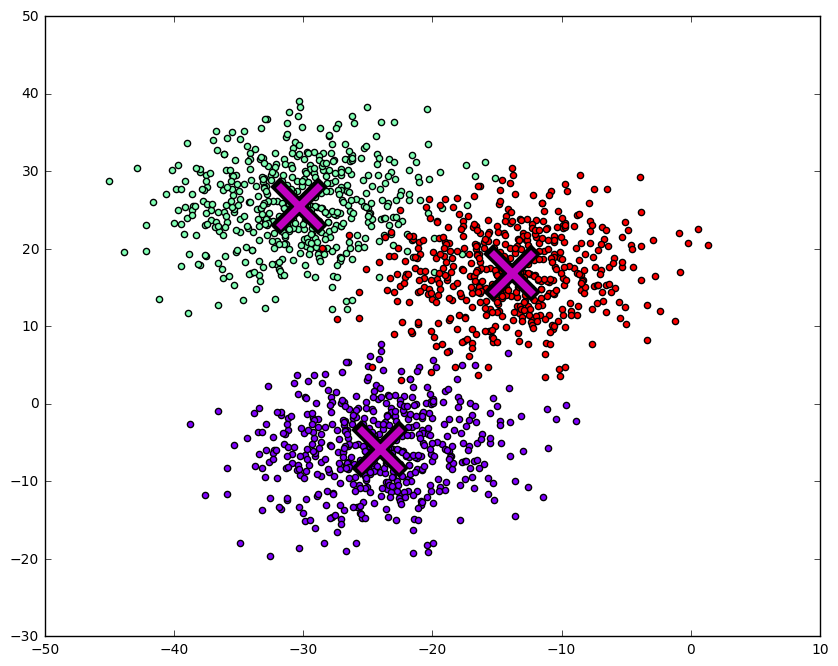

In [4]:
plot_clusters(sample_values, centroid_values, n_samples_per_cluster)

Initialisation

The k-means algorithm starts with the choice of the initial centroids, which are just random guesses of the actual centroids in the data. The following function will randomly choose a number of samples from the dataset to act as this initial guess:

In [5]:
def choose_random_centroids(samples, n_clusters):
    # Step 0: Initialisation: Select `n_clusters` number of random points
    n_samples = tf.shape(samples)[0]
    random_indices = tf.random_shuffle(tf.range(0, n_samples))
    begin = [0,]
    size = [n_clusters,]
    size[0] = n_clusters
    centroid_indices = tf.slice(random_indices, begin, size)
    initial_centroids = tf.gather(samples, centroid_indices)
    return initial_centroids
    

This code first creates an index for each sample (using tf.range(0, n_samples), and then randomly shuffles it. From there, we choose a fixed number (n_clusters) of indices using tf.slice. These indices correlated to our initial centroids, which are then grouped together using tf.gather to form our array of initial centroids.

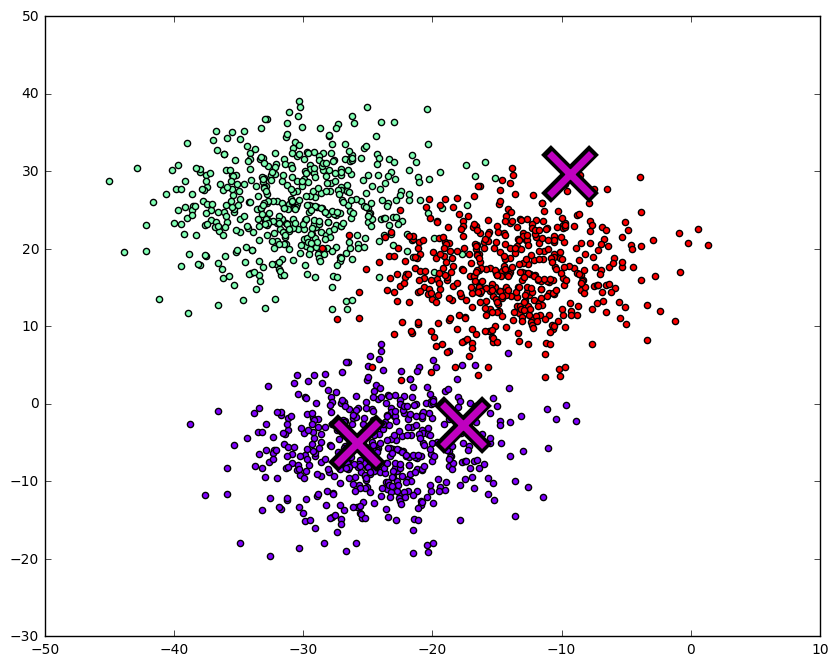

In [6]:

centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
initial_centroids = choose_random_centroids(samples, n_clusters)

model = tf.global_variables_initializer()
with tf.Session() as session:
    sample_values = session.run(samples)
    updated_centroid_value = session.run(initial_centroids)

plot_clusters(sample_values, updated_centroid_value, n_samples_per_cluster)

The major change here is that we create a variable for these initial centroids, and compute its value in the session. We then plot out those first guesses to plot_cluster, rather than the actual centroids that were used to generate the data.

### Updating Centroids

After starting with some guess for the centroid locations, the k-means algorithm then updates those guesses based on the data. The process is to assign each sample a cluster number, representing the centroid it is closest to. After that, the centroids are updated to be the means of all samples assigned to that cluster. The following code handles the assign to nearest cluster step:

In [7]:
def assign_to_nearest(samples, centroids):
    # Finds the nearest centroid for each sample

    # START from http://esciencegroup.com/2016/01/05/an-encounter-with-googles-tensorflow/
    expanded_vectors = tf.expand_dims(samples, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum( tf.square(
               tf.subtract(expanded_vectors, expanded_centroids)), 2)
    mins = tf.argmin(distances, 0)
    # END from http://esciencegroup.com/2016/01/05/an-encounter-with-googles-tensorflow/
    nearest_indices = mins
    return nearest_indices

The way this works is to compute the distance between each sample and each centroid, which occurs through the distances = line. The distance computation here is the Euclidean distance. An important point here is that tf.sub will automatically expand the size of the two arguments. This means that having our samples as a matrix, and the centroids as a column vector will produce the pairwise subtraction between them. In order to do this, we use tf.expand_dims to create an extra dimension for both samples and centroids, forcing this behaviour of tf.sub.

The next bit of code hands the update centroids bit:

In [21]:
def update_centroids(samples, nearest_indices, n_clusters):
    # Updates the centroid to be the mean of all samples associated with it.
    nearest_indices = tf.to_int32(nearest_indices)
    print(nearest_indices)
    partitions = tf.dynamic_partition(samples, nearest_indices, n_clusters)
    partitions=tf.to_int32(nearest_indices)
    print(partitions)
    new_centroids = tf.concat(0,[tf.expand_dims(tf.reduce_mean(partition, 0), 0) for partition in partitions])
    return new_centroids

This code takes the nearest indices for each sample, and grabs those out as separate groups using tf.dynamic_partition. From here, we use tf.reduce_mean on a single group to find the average of that group, forming its new centroid. From here, we just tf.concat them together to form our new centroids.

Now we have the piece in place, we can add these calls to our script (or create a new one):

In [22]:

data_centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
initial_centroids = choose_random_centroids(samples, n_clusters)
nearest_indices = assign_to_nearest(samples, initial_centroids)
updated_centroids = update_centroids(samples, nearest_indices, n_clusters)

model = tf.global_variables_initializer()
with tf.Session() as session:
    sample_values = session.run(samples)
    updated_centroid_value = session.run(nearest_indices)
    print(updated_centroid_value)

plot_clusters(sample_values, updated_centroid_value, n_samples_per_cluster)

Tensor("ToInt32_8:0", shape=(1500,), dtype=int32)
Tensor("ToInt32_8:0", shape=(1500,), dtype=int32)


TypeError: 'Tensor' object is not iterable.

In [ ]:
print(initial_centroids.shape)

This code will:

    1-Generate samples from initial centroids
    2-Randomly choose initial centroids
    3-Associate each sample to its nearest centroid
    4-Update each centroid to be the mean of the samples associated to it

This is a single iteration of k-means! I encourage you to take a shot at the exercises, which turns this into an iterative version.